## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file
file_name="complaints-2021-05-14_08_16.json"
f = file = open(file_name, "r")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [6]:
df.shape

(78313, 22)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided
78312,complaint-public-v2,complaint,2001189,0.0,None,None,2001189,Payment to acct not credited,2016-07-06T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-07-07T12:00:00-05:00,None,None,Yes,Roughly 10+ years ago I closed out my accounts...,None,Consent provided


In [9]:
df.shape

(78313, 22)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [11]:
# checking for missing values
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)


_source.company_public_response      0.999949
_source.tags                         0.860815
_source.sub_issue                    0.591179
_source.sub_product                  0.134984
_source.zip_code                     0.086282
_source.state                        0.025424
_source.consumer_consent_provided    0.012871
_source.company                      0.000000
_source.complaint_what_happened      0.000000
_source.timely                       0.000000
_source.date_sent_to_company         0.000000
_source.submitted_via                0.000000
_index                               0.000000
_source.company_response             0.000000
_type                                0.000000
_source.consumer_disputed            0.000000
_source.date_received                0.000000
_source.issue                        0.000000
_source.complaint_id                 0.000000
_score                               0.000000
_id                                  0.000000
_source.product                   

In [13]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [14]:
#Assign new column names
def rename_col(col):
    if col.startswith('_source'):
        col = col[len('_source.'):]
    elif col.startswith('_'):
        col = col[1:]
    return col

In [15]:
df.rename(lambda x: rename_col(x), axis=1, inplace=True)

In [16]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [17]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)


/var/folders/nq/3fxqklb97yz93462sr2ymsrr0000gn/T/ipykernel_8256/2492469932.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [19]:
#Remove all rows where complaints column is nan

df['complaint_what_happened'].isnull().sum()

57241

In [20]:
#Remove all rows where complaint_what_happened column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [21]:
df['complaint_what_happened'].isna().sum()

0

In [22]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [23]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'\[.*?\]',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'\n', '', text) # Remove line breaks
  text=re.sub(r'\b\w*\d\w*\b',' ',text) #Remove words with numbers
  text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces

  return text

In [25]:
df.shape

(21072, 22)

In [26]:
#Write your function to Lemmatize the texts
import spacy
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and remove stop words
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])

    return lemmatized_text

In [28]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints


In [29]:
# Apply data cleaning to the complaints_what_happened column
from tqdm import tqdm
# Use progress_apply from tqdm on the Series
tqdm.pandas()
df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaint_what_happened'].progress_apply(lambda x: clean_text(x))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21072/21072 [00:02<00:00, 9890.91it/s]


In [30]:
df_clean.shape

(21072, 1)

In [31]:
tqdm.pandas()
df_clean['lemmatized'] = df_clean['complaints'].progress_apply(lambda x:lemmatize_text(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21072/21072 [15:31<00:00, 22.63it/s]


In [32]:
df_clean.shape

(21072, 2)

In [33]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...
10,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...
11,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [34]:
df_clean.shape

(21072, 2)

In [35]:
!pip install swifter

  Using cached swifter-1.4.0.tar.gz (1.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached dask-2024.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached dask_expr-1.1.16-py3-none-any.whl.metadata (2.5 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached dask-2024.10.0-py3-none-any.whl (1.3 MB)
Using cached cloudpickle-3.1.0-py3-none-any.whl (22 kB)
Using cached dask_expr-1.1.16-py3-none-any.whl (243 kB)
Using cached partd-1.4.2-py3-none-any.whl (18 kB)
Using cached toolz-1.0.0-py3-none-any.whl (56 kB)
Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=1cb78143ed80cb48e1a38ecf7fb3b08c991163a70f6961938a9d664c097ab4f5
  Stored in directory: /Users/vkrkscb/Library/Cac

In [36]:
#Write your function to extract the POS tags
import swifter

def pos_tag(text):
  nn_words = []
  doc = nlp(text)
  for tok in doc:
      if(tok.tag_ == 'NN'):
          nn_words.append(tok.lemma_)
  nn_words_str = " ".join(nn_words)
  return nn_words_str


df_clean['complaint_POS_removed'] = df_clean['lemmatized'].swifter.apply(pos_tag) # used swifter to enhance the performance
 #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [37]:
df_clean.shape

(21072, 3)

In [38]:
df_clean['complaint_POS_removed']

1        morning help bank service write chase debt ver...
2        card agent upgrade anniversary date change age...
10       chase card report application submit identity ...
11       book offer ticket reward card information minu...
14       son deposit chase account fund bank account pa...
                               ...                        
78303    chase card customer decade solicitation credit...
78309    credit card provider ask claim purchase protec...
78310    xxxx risk consumer year trust mobile banking t...
78311    credit yrs credit card chase freedom problem t...
78312    year account order line credit account payment...
Name: complaint_POS_removed, Length: 21072, dtype: object

In [39]:
df_clean.shape

(21072, 3)

In [40]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,chase card report application submit identity ...
11,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...


In [41]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.


In [42]:
filtered_df = df_clean[df_clean['complaint_POS_removed'].notna()]

filtered_df

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,chase card report application submit identity ...
11,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxxx ...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...
78311,i have had flawless credit for yrs i ve had ch...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




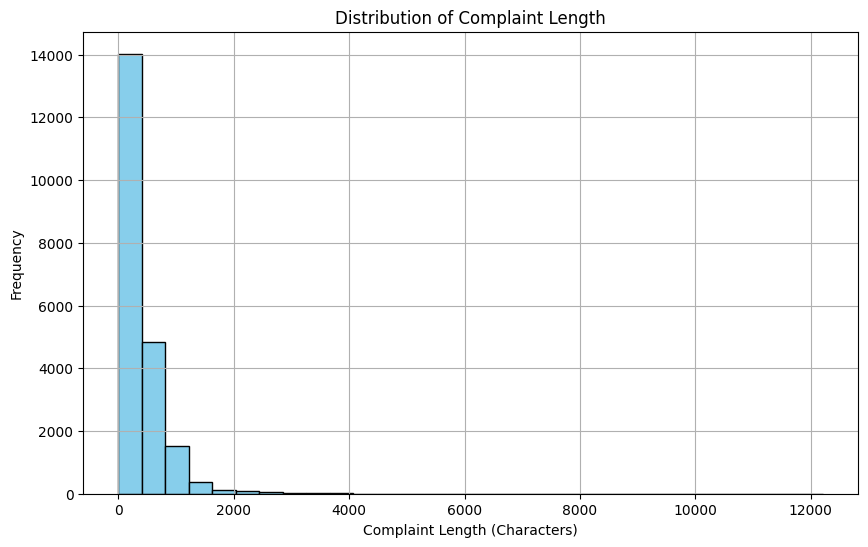

In [43]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
plt.hist(df_clean['complaint_POS_removed'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Complaint Length (Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Length')
plt.grid(True)
plt.show()

In [44]:
df_clean['complaint_POS_removed']

1        morning help bank service write chase debt ver...
2        card agent upgrade anniversary date change age...
10       chase card report application submit identity ...
11       book offer ticket reward card information minu...
14       son deposit chase account fund bank account pa...
                               ...                        
78303    chase card customer decade solicitation credit...
78309    credit card provider ask claim purchase protec...
78310    xxxx risk consumer year trust mobile banking t...
78311    credit yrs credit card chase freedom problem t...
78312    year account order line credit account payment...
Name: complaint_POS_removed, Length: 21072, dtype: object

#### Find the top 40 words by frequency among all the articles after processing the text.

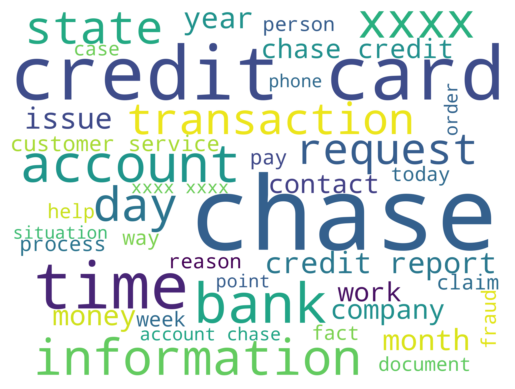

In [45]:
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=spacy.lang.en.stop_words.STOP_WORDS, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [46]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [47]:
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [48]:
def get_top_ngram_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [49]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram = get_top_ngram_words(df_clean['Complaint_clean'], 1,30)


In [50]:
#Print the top 10 words in the unigram frequency
for word, freq in unigram[:10]:
        print(word, freq)


chase 51987
account 40169
credit 33623
card 29780
xxxx 29651
payment 21282
time 16147
bank 15952
charge 15214
day 13110


In [52]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_ngram_words(df_clean['Complaint_clean'], 2,30)


In [53]:
#Print the top 10 words in the bigram frequency
for word, freq in bigram[:10]:
        print(word, freq)

credit card 12821
credit report 3858
chase credit 3040
customer service 2919
call chase 2573
xxxx xxxx 2173
account chase 2144
check account 2039
chase bank 1968
chase account 1926


In [55]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_ngram_words(df_clean['Complaint_clean'], 3,30)


In [56]:
#Print the top 10 words in the trigram frequency
for word, freq in trigram[:10]:
        print(word, freq)

chase credit card 2193
credit card account 1042
credit card company 969
credit card chase 726
xxxx credit card 682
xxxx xxxx xxxx 662
chase customer service 547
inquiry credit report 471
credit card credit 434
credit card xxxx 410


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [58]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [59]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,chase card report application submit identity ...,chase card report application submit identity ...
11,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,book offer ticket reward card information minu...,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxxx ...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,risk consumer year trust mobile banking tell ...
78311,i have had flawless credit for yrs i ve had ch...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...


In [60]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [61]:
#Write your code here to initialise the TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with max_df and min_df parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [62]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Fit and transform the raw texts to TF-IDF features
tfidf = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Now tfidf_matrix contains the TF-IDF features of the texts

In [63]:
print(tfidf.shape)

(21072, 6107)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [64]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [65]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40) #write your code here


In [66]:
nmf_model.fit(tfidf)
len(tfidf_vectorizer.get_feature_names_out())

6107

In [67]:
#Print the Top15 words for each of the topics
n_top_words = 15
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([",".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])])
    print()

Topic 1:
['chase,dispute,card,charge,transaction,claim,fraud,merchant,letter,call,email,number,phone,contact,purchase']

Topic 2:
['account,check,money,deposit,bank,fund,chase,branch,day,transfer,business,number,cash,call,reason']

Topic 3:
['payment,loan,mortgage,chase,month,modification,home,year,time,pay,interest,property,rate,auto,foreclosure']

Topic 4:
['credit,card,report,inquiry,account,score,chase,company,limit,debt,application,year,reporting,information,remove']

Topic 5:
['fee,charge,balance,interest,overdraft,card,pay,statement,month,rate,account,bill,purchase,transfer,payment']



In [68]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)


array([1, 0, 3, ..., 0, 2, 2])

In [69]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [70]:
df_clean.shape

(21072, 5)

In [71]:
df_clean.head()['Complaint_clean']

1     morning help bank service write chase debt ver...
2     card agent upgrade anniversary date change age...
10    chase card report application submit identity ...
11    book offer ticket reward card information minu...
14    son deposit chase account fund bank account pa...
Name: Complaint_clean, dtype: object

In [72]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')


,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,0
43,chase sent me an email today with the innocuou...,chase send email today innocuous title importa...,chase email today title information change cha...,chase email today title information change cha...,0
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair deliver d...,seat table chair deliver debit card charge ban...,seat table chair deliver debit card charge ban...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,catering order place brother contact chase noo...,catering order place brother contact chase noo...,0
21,on xxxx xx xx i made a payment to an online re...,xxxx xx xx payment online retailer chase quick...,xxxx payment retailer chase pay website scam w...,payment retailer chase pay website scam websi...,0
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,1
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,mishandle account chase auto xxxx,mishandle account chase auto,1
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,account call term account xxxx deposit bonus p...,account call term account deposit bonus pay d...,1
17,with out notice j p morgan chase restricted my...,notice j p morgan chase restrict account debit...,account debit card branch customer service rep...,account debit card branch customer service rep...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,1


In [73]:
 df_clean_5.shape

(25, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [74]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Theft/Dispute Reporting',
    1: 'Bank Account services',
    2: 'Mortgage/Loan',
    3: 'Credit card / Prepaid card',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [75]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized             21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [76]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [77]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,Theft/Dispute Reporting
10,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,chase card report application submit identity ...,chase card report application submit identity ...,Credit card / Prepaid card
11,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,Credit card / Prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,on wednesday xx xx xxxx i called chas my xxxx ...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,risk consumer year trust mobile banking tell ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs i ve had ch...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...,Mortgage/Loan


In [78]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=training_data = df_clean[["complaints", "Topic"]].copy()

In [79]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx and was ...,Theft/Dispute Reporting
10,chase card was reported on xx xx however fraud...,Credit card / Prepaid card
11,on xx xx while trying to book a xxxx xxxx tick...,Credit card / Prepaid card
14,my grand son give me check for i deposit it in...,Bank Account services
...,...,...
78303,after being a chase card customer for well ove...,Credit card / Prepaid card
78309,on wednesday xx xx xxxx i called chas my xxxx ...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs i ve had ch...,Mortgage/Loan


In [80]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized             21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

count_vect=CountVectorizer()
#Write your code to get the Vector count
X_train_counts=count_vect.fit_transform(training_data['complaints'])
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tfidf=tfidf_transformer.fit_transform(X_train_counts)

In [82]:
X_train_tfidf.shape[1]

28025

In [84]:
# Here we can see that, there is data imbalaced, but not much.

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [85]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [86]:
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [87]:
from sklearn.model_selection import train_test_split
# Train-Test split

train_X, test_X, train_y, test_y = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)


In [88]:
print('train_X shape: ', train_X.shape)
print('train_y shape: ', train_y.shape)
print('test_X shape: ', test_X.shape)
print('test_y shape: ', test_y.shape)

train_X shape:  (16857, 28025)
train_y shape:  (16857,)
test_X shape:  (4215, 28025)
test_y shape:  (4215,)


In [89]:
# importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [90]:
# evaluate models
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    # Use the built-in round function instead of the method
    print('Accuracy: ', round(accuracy_score(y_test,y_pred), 2))
    print('Precision: ', round(precision_score(y_test,y_pred,average='weighted'), 2))
    print('Recall: ', round(recall_score(y_test,y_pred,average='weighted'), 2))
    print('F1 Score: ', round(f1_score(y_test,y_pred,average='weighted'), 2))
    print('ROC AUC Score: ', round(roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr'), 2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [91]:
# run model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  0.96
Precision:  0.96
Recall:  0.96
F1 Score:  0.96
ROC AUC Score:  1.0
Classification Report:                              precision    recall  f1-score   support

     Bank Account services       0.96      0.97      0.96      4202
Credit card / Prepaid card       0.96      0.97      0.97      3459
             Mortgage/Loan       0.97      0.97      0.97      3621
                    Others       0.98      0.90      0.94      1701
   Theft/Dispute Reporting       0.94      0.96      0.95      3874

                  accuracy                           0.96     16857
                 macro avg       0.96      0.95      0.96     16857
              weighted avg       0.96      0.96      0.96     16857

Test results
Accuracy:  0.91
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                              precision    recall  f1-score   support

     Bank Ac

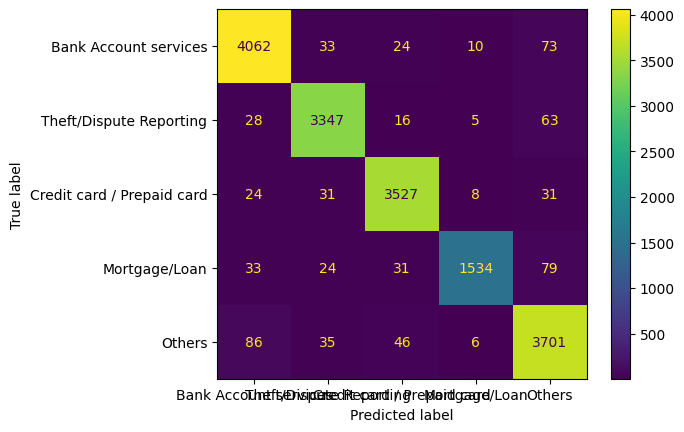

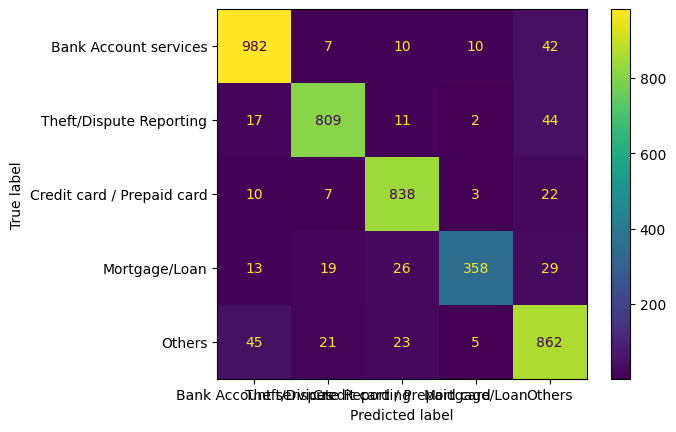

In [92]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
lr_model=run_model(LogisticRegression(),params)
eval_model(train_y,lr_model.predict(train_X),lr_model.predict_proba(train_X),type='Training')
eval_model(test_y,lr_model.predict(test_X),lr_model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                              precision    recall  f1-score   support

     Bank Account services       1.00      1.00      1.00      4202
Credit card / Prepaid card       1.00      1.00      1.00      3459
             Mortgage/Loan       1.00      1.00      1.00      3621
                    Others       1.00      1.00      1.00      1701
   Theft/Dispute Reporting       1.00      1.00      1.00      3874

                  accuracy                           1.00     16857
                 macro avg       1.00      1.00      1.00     16857
              weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.75
Precision:  0.75
Recall:  0.75
F1 Score:  0.75
ROC AUC Score:  0.84
Classification Report:                              precision    recall  f1-score   support

     Bank Accoun

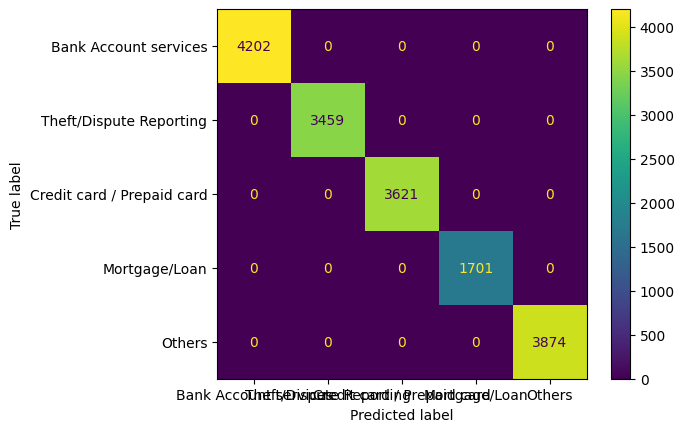

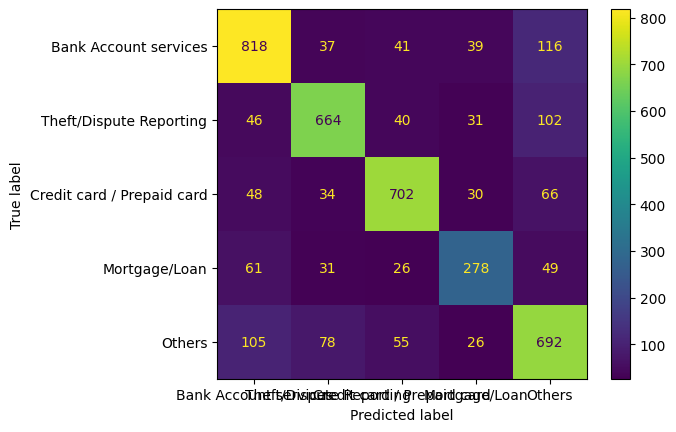

In [93]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10,12],
    'min_samples_split': [2, 4, 6, 8, 10,15],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10,12],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
dtr_model=run_model(DecisionTreeClassifier(),params)
eval_model(train_y,dtr_model.predict(train_X),dtr_model.predict_proba(train_X),type='Training')
eval_model(test_y,dtr_model.predict(test_X),dtr_model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                              precision    recall  f1-score   support

     Bank Account services       1.00      1.00      1.00      4202
Credit card / Prepaid card       1.00      1.00      1.00      3459
             Mortgage/Loan       1.00      1.00      1.00      3621
                    Others       1.00      1.00      1.00      1701
   Theft/Dispute Reporting       1.00      1.00      1.00      3874

                  accuracy                           1.00     16857
                 macro avg       1.00      1.00      1.00     16857
              weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.81
Precision:  0.81
Recall:  0.81
F1 Score:  0.8
ROC AUC Score:  0.97
Classification Report:                              precision    recall  f1-score   support

     Bank Account

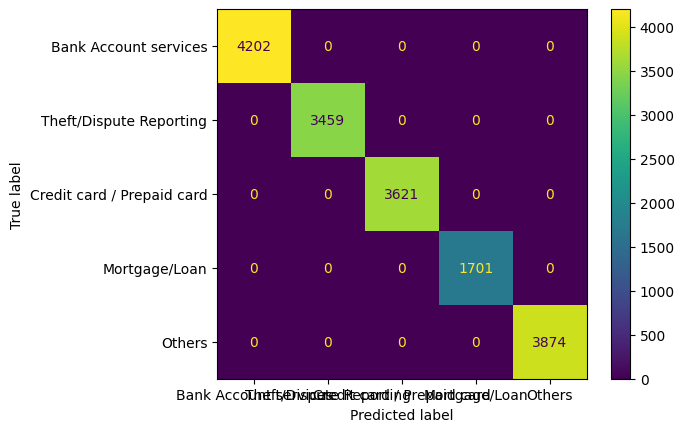

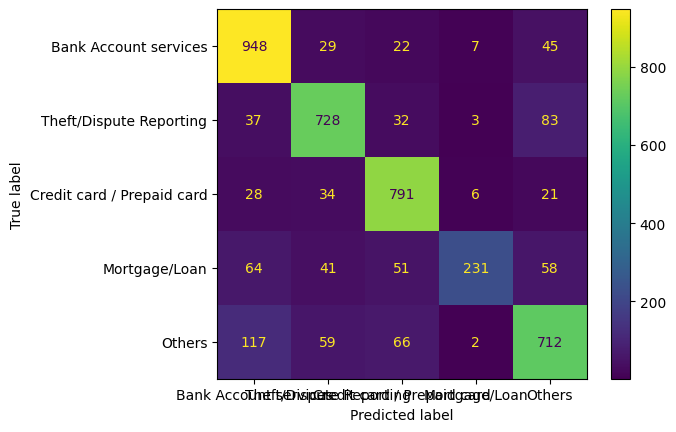

In [94]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100, 200, 400,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10,15],
    'min_samples_split': [2, 4, 6, 8, 10,20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10,12],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_model=run_model(RandomForestClassifier(),params)
eval_model(train_y,rf_model.predict(train_X),rf_model.predict_proba(train_X),type='Training')
eval_model(test_y,rf_model.predict(test_X),rf_model.predict_proba(test_X),type='Test')

### Results on Test Data

### Conclusions

In [97]:
# Applying the best model on the Custom Text
# We will use the Logistic Regression model as it has the best performance
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})

In [98]:
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [99]:
def predict_lr(text):
    Topic_names = {
        0: 'Theft/Dispute Reporting',
        1: 'Bank Account services',
        2: 'Mortgage/Loan',
        3: 'Credit card / Prepaid card',
        4: 'Others'
    }
    X_new_counts = count_vect.transform([text])  # Pass text as a list containing one string
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr_model.predict(X_new_tfidf)
    predicted_label = predicted[0]
    if isinstance(predicted_label, int):
        return Topic_names[predicted_label]
    else:
        # If the predicted label is a string, return it directly
        return predicted_label

In [100]:
# predicted text
df_complaints['predicted_label'] = df_complaints['complaints'].apply(predict_lr)
df_complaints

,complaints,predicted_label
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card / Prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Credit card / Prepaid card
5,I need to know the number of bank branches and...,Bank Account services
